# RAG tutorial

Rag stands for *Retrieval Augmented Generation* the idea is to provide the LLM with some context to aid it generate better results. There are many ways one can set up rag. There are a lot of commercial and semi-commercial tools one can use. We will explore some basic elements of RAG and generate some of the componenets. We will **not** generate a fully functioning RAG as there are many componenets to it and we might not have time. I will introduce some of the tools that one can use while building a rag system. 
Oveall the general architecture would look something like this. 


<div>
<img src="https://huggingface.co/datasets/huggingface/cookbook-images/resolve/main/RAG_workflow.png" width="600"/>
</div>

## Knowledge Base

This is very context dependent, but basically something you curate before you even think about building a RAG. I would think that it's the other way around that is you will have a knowledge base already and you thinkg RAG would be a good way to use it. 

There are couple of things we would need to do make sure that our knowledge base is useful. 

1. Process the documents this involves:
    +  Getting the documents in a format that is machine readable,
    +  Chunking large documents into smaller bits and pieces so we do not run out of context length
    +  embedding the text, (we will need to pick an embedding model that is suitable for this task)
    +  Store it in a place that is searchable

Because we have limited time I will be using a simple dataset, the yelp review dataset. This is already in a machine readable format so we don't really need to do anything other than load it. There are a few different kinds of datasets, I will just be using the business one since it is smaller and quicker to load. 

In [1]:
import os
import json
with open("yelp_reviews.json") as data:
    reviews=data.read()

In [2]:
reviews=reviews.split("\n")

In [3]:
reviews[len(reviews)-1]

''

In [4]:
reviews=[json.loads(item) for item in reviews if len(item)>0]

In [5]:
import pandas as pd
reviews=pd.DataFrame.from_records(reviews)

In [6]:
reviews

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15
...,...,...,...,...,...,...,...,...,...
995,XMWg7adwVBKqIl_e_TTtuA,syyKcKPFILDysHWmtka-aA,1_hDCN3iioFR3XnUr32ZtA,5.0,0,0,0,I Recently vacationed in St. Petersburg with m...,2014-06-28 03:00:56
996,BGZ3GtcXhtIEPIkyLVuKDQ,_lgLNzpzf3qmbwySBakxEw,5RzJ2bjU8bLSaN5SuiUpYA,4.0,1,0,1,Very cool bar attached to the Alexander Hotel....,2016-01-17 16:45:19
997,lm7Q8pH26kqx1gbjCJ16ZQ,Sh_vUlHHY2Kuj14eF8NYZQ,s1PNBO9o5jIgNd5YWUDLXQ,5.0,1,0,0,This hotel is a gem in the heart of Philadelph...,2016-02-23 21:31:39
998,Lo2giVeSNDvatEAGZRikWQ,YwMD-AVT67fmYRGxnlRSPA,alUk6OwNhofyc90NDMDY-Q,5.0,7,1,0,Was taken here today by a Colombian friend who...,2010-08-22 01:54:23


Ok we have our dataset ready, I am interested in the text portion. I will do a simple check to see how many words are in the dataset so we will know whether we need to chunk them. 

<Axes: >

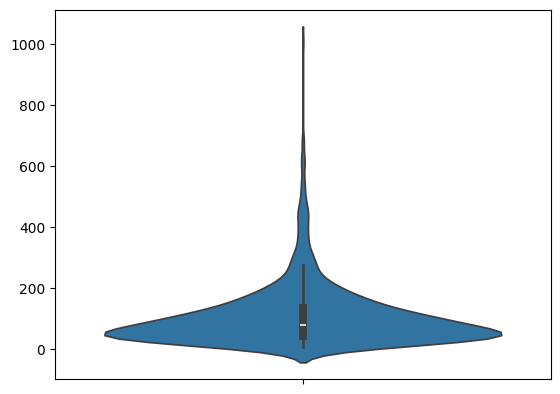

In [7]:
import seaborn as sns
lengths=[len(item.split(" ")) for item in reviews["text"]]
sns.violinplot(lengths)

Some of these are fairly lengthy, we will need to chunk them into pieces. There are many ways to do that. But first let's find an embedding model that we will be using. Since we do not have enough time I will just get a small model. There are also many ways one can encode a model. We can use sentence transformers, transformers itself or other tools like Langchain (we'll talk about that below) or even hosted models commercial and self hosted (like ollama). 

The mode I will be using is all-MiniLM-L6-v2, it has a context length of 512. So anything above that will need to be chunked. There are many way we can split this based on several factors and that in turn will depend on the kind of input we have. Some options are

+ Based on number of words/characters/tokens
+ Based on paragraphs for longer texts
+ Rule based (spacy, nltk)
+ Based on texts for structured input (markdown, xml, html, code-language dependent)
+ Semantic based

The last one is a little different and may need some explanation. Let's say our context length takes about 50 sentences (10 words per sentence). We take the first 10 sentences or 100 tokens, calculate embeddings and move on to the next one, if there is a large difference in the embedding similiarity then we create a new chunk. This is more time consuming than the rest of the methods and will be very specific to a use case. 



In [8]:
# implementing a text splitter using a huggingface tokenizer

from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2').to("cuda")


/home/alper/miniconda3/envs/rag/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
from langchain_text_splitters import CharacterTextSplitter

text_splitter = CharacterTextSplitter.from_huggingface_tokenizer(
    tokenizer, chunk_size=350, chunk_overlap=0
)


In [10]:
splits=[text_splitter.split_text(text) for text in reviews["text"].tolist()]

Created a chunk of size 429, which is longer than the specified 350
Token indices sequence length is longer than the specified maximum sequence length for this model (556 > 512). Running this sequence through the model will result in indexing errors
Created a chunk of size 363, which is longer than the specified 350


In [11]:
splitted=[]
for item in splits:
    if len(item)==1:
        continue
    else:
        splitted.append(item)
        

In [12]:
#let's look at an example
splitted[0]

['The only reason I didn\'t give this restaurant a 5 star rating, is because of one single pretentious waiter. As a 4 night guest at Hotel Palomar, the location of the restaurant is an obvious plus. The first night of my stay, I met a coworker in the restaurant for a cocktail. When we arrived, the host staff were busy and not available, so we just walked in. The restaurant was not too busy, so we just looked at a small table next to the bar and proceeded to take a seat. A waiter came by and I quickly asked if we could have a seat, before sitting down and told him we\'d only be having cocktails. He stumbled on his reply, and in an irritated/in-convinced tone, told me "I guess it would be fine" and basically just kept walking mid sentence. My guest and I brushed it off, and started having a conversation while looking at the drink menu. To make a long story short, he was distant and we both got the "couldn\'t be bothered" vibe from him. When it came to the bill, we asked if it could be sp

Ok now it's time to create embeddings, keep in mind that we have a list of lists but we are not going to keep it that way for today, it will just be a list of embeddings. There are other methods that I will mention might keep the overall structure of the notes and we can retrieve the n closest text even if one of the chunks are in the top n. If we are using sentence transformers the package generates the mean pooling for us but for practice reasons we will write our own. 

In [13]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

In [14]:
# combine all the items in the splits in to a single list
combined=[]
for item in splits:
    for chunk in item:
        combined.append(chunk)

In [15]:
import torch
from tqdm import tqdm

embeddings=[]

for item in tqdm(combined):
    tokenized=tokenizer(item, padding=True, truncation=True, return_tensors="pt").to("cuda")    
    with torch.no_grad():
        model_output = model(**tokenized)
    sentence_embeddings = mean_pooling(model_output, tokenized['attention_mask'])
   
    embeddings.append(sentence_embeddings)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1063/1063 [00:02<00:00, 492.23it/s]


In [16]:
embeddings[0].shape

torch.Size([1, 384])

In [17]:
# we can also use LangChain for this

from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings

embedding_model = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2",
    multi_process=True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},  # Set `True` for cosine similarity
)

/tmp/ipykernel_96971/3404784880.py:6: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(


In [18]:
from langchain_community.vectorstores.utils import DistanceStrategy

# we need to create a new split dataset with metadata for this to work this methods conserves document integrity

splits=text_splitter.create_documents(reviews["text"].tolist())

Created a chunk of size 429, which is longer than the specified 350
Created a chunk of size 363, which is longer than the specified 350


In [19]:
vector_store = FAISS.from_documents(
    splits, embedding_model, distance_strategy=DistanceStrategy.COSINE
)

In [42]:
# perform a search for similar documents

query="Can you write a positivie restaruant review?"

In [43]:
retrieved_docs = vector_store.similarity_search(query=query, k=5)

In [44]:
retrieved_docs

[Document(id='50825e83-7c42-4db0-92f1-94c6477f96ce', metadata={}, page_content='I was a little worried about seeing the reviews but everything. Was great! Not long wait time. Staff was nice from walking in the lobby and asking which way to the office, to the office staff.'),
 Document(id='08368c3d-bb6c-4267-9af3-cefbc3bfc468', metadata={}, page_content="I was here a few times before and didn't review. I come here for the food, NOT the service. The establishment is lacking in its service. Their food is always great though! Very delicious for a dive bar."),
 Document(id='c495eac8-a1b6-4585-9354-c5e77e6ea89b', metadata={}, page_content='I really love going to cool, popular restaurants and having a great time, and I hate writing such a negative review, but I had to share my experience, especially for a restaurant that is getting an awful lot of (undeserved) hype.'),
 Document(id='f9833fa6-d61b-4b28-986f-97569b1ffafa', metadata={}, page_content="Not too sure why all the negative reviews. I 

A little side not on matroshka embeddings. 

Our model generates embeddings in 384 dimensions, there are other models that use higher dimensions, usually higher dimensionality is correlated with better representation. But that also means longer preprocessing times, larger vectors to store and search. Can we create shorter embeddings that are almost as good with half the length or even shorter?

Matryoshka Embeddings do just that, these models not just train the model for embeddings but the loss function also evaluates shorter embeddings at different dimensions. If needed we can use thsese models to reduce our computational burden for search and pre-processing. 

<div>
<img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/blog/matryoshka/matryoshka-small.gif" width="600"/>
</div>

Ok, now that we are done with our vector store, how can we pass this onto the LLM? First we need to pick an llm, I will be using a small model and we will make it even smaller by 4bit quantizing it. 

In [23]:
from transformers import pipeline
from transformers import AutoModelForCausalLM, BitsAndBytesConfig

In [33]:
llm="unsloth/granite-3.2-8b-instruct-unsloth-bnb-4bit"


In [35]:
llm_model = AutoModelForCausalLM.from_pretrained(llm).to("cuda")
llm_tokenizer = AutoTokenizer.from_pretrained(llm)

`low_cpu_mem_usage` was None, now default to True since model is quantized.
You shouldn't move a model when it is dispatched on multiple devices.


In [51]:
pipe = pipeline(
    model=llm_model,
    tokenizer=llm_tokenizer,
    task="text-generation",
    do_sample=True,
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=300)

Device set to use cuda:0


In [53]:
pipe(query)

[{'generated_text': "\n\n★★★★★ Absolutely delightful dining experience! The moment we stepped into this charming restaurant, we were greeted with warm smiles and a cozy ambiance. The menu offered a delightful array of dishes, each more tantalizing than the last. I opted for the signature dish, which was a masterpiece of flavors and textures. The presentation was impeccable, and every bite was a symphony of taste. The service was attentive yet unobtrusive, ensuring our glasses never ran dry and our needs were met promptly. The staff's knowledge of the menu and wine pairings was commendable. This restaurant is a must-visit for food lovers seeking an exceptional culinary journey. Highly recommended!"}]

In [41]:
rag_prompt = [{"role": "system", 
             "content":"Using the information contained in the context answer the question. Only provide answer to the question and nothing else. "}, 
             {"role":"user", 
              "content": """
              
              Context: {context}

              Question: {question}
              """}]

prompt_template=llm_tokenizer.apply_chat_template(rag_prompt, tokenize=False, add_generation_prompt=True)

In [59]:
retrieved_docs_text = [doc.page_content for doc in retrieved_docs]
context = "\nExtracted documents:\n"
context += "".join([f"Document {str(i)}:::\n" + doc for i, doc in enumerate(retrieved_docs_text)])
print(context)


Extracted documents:
Document 0:::
I was a little worried about seeing the reviews but everything. Was great! Not long wait time. Staff was nice from walking in the lobby and asking which way to the office, to the office staff.Document 1:::
I was here a few times before and didn't review. I come here for the food, NOT the service. The establishment is lacking in its service. Their food is always great though! Very delicious for a dive bar.Document 2:::
I really love going to cool, popular restaurants and having a great time, and I hate writing such a negative review, but I had to share my experience, especially for a restaurant that is getting an awful lot of (undeserved) hype.Document 3:::
Not too sure why all the negative reviews. I was in and out within 5 mins. Maybe it was because I wasn't looking for something elaborate, who knows. Anyways, I got exactly what I needed and the employees were courteous. The store was organized, well stocked and clean. Unfortunately for this area ho

In [47]:
final_prompt = prompt_template.format(question=query, context=context)

In [58]:
print(final_prompt)

<|start_of_role|>system<|end_of_role|>Using the information contained in the context answer the question. Only provide answer to the question and nothing else. <|end_of_text|>
<|start_of_role|>user<|end_of_role|>
              
              Context: 
Extracted documents:
Document 0:::
I was a little worried about seeing the reviews but everything. Was great! Not long wait time. Staff was nice from walking in the lobby and asking which way to the office, to the office staff.Document 1:::
I was here a few times before and didn't review. I come here for the food, NOT the service. The establishment is lacking in its service. Their food is always great though! Very delicious for a dive bar.Document 2:::
I really love going to cool, popular restaurants and having a great time, and I hate writing such a negative review, but I had to share my experience, especially for a restaurant that is getting an awful lot of (undeserved) hype.Document 3:::
Not too sure why all the negative reviews. I was

In [57]:
answer = pipe(final_prompt)[0]["generated_text"]

print(answer)

Absolutely, here's a positive restaurant review:

Title: Exceptional Dining Experience at [Restaurant Name]

I recently had the pleasure of visiting [Restaurant Name], and I am thrilled to share my outstanding experience. From the moment I stepped into the establishment, the warm and inviting ambiance immediately put me at ease.

The staff was exceptionally friendly and attentive without being intrusive. They were knowledgeable about the menu and provided excellent recommendations based on my preferences. The service was prompt yet unhurried, ensuring a relaxed dining atmosphere.

The food was nothing short of extraordinary. Each dish was beautifully presented and bursting with flavor. The quality of ingredients was evident, and every bite was a delightful surprise. Special mention goes to their signature dishes - they truly stand out.

What sets this restaurant apart is its commitment to customer satisfaction. On our visit, we mentioned that we appreciated a later check-out time, and 

RAG is mainly used to minimize hallucinations, this is not done via training but by proving the model a context to work with. For genrative tasks it works surprisingly well. For question and answering it is very dependent of how the model is trained and its capabilities. As usual with LLMs more is more, given all things equal a bigger model will perform better. If you are interested in Q&A reasoning models will work better. Regardless of the task, RAG is a relatively simple way to nudge your model in the right direction.